In [1]:
import json
import math
import os
import time
import pickle as pkl

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tr

import torch_geometric
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch
from torch_geometric.nn.conv import MessagePassing, GravNetConv
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [2]:
# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

# VICReg loss function
def criterion(x, y, device="cuda", lmbd=0.01, u=0.1, v=0.1, epsilon=1e-3):
    bs = x.size(0)
    emb = x.size(1)

    std_x = torch.sqrt(x.var(dim=0) + epsilon)
    std_y = torch.sqrt(y.var(dim=0) + epsilon)
    var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))

    invar_loss = F.mse_loss(x, y)

    xNorm = (x - x.mean(0)) / x.std(0)
    yNorm = (y - y.mean(0)) / y.std(0)
    crossCorMat = (xNorm.T @ yNorm) / bs
    cross_loss = (
        (
            crossCorMat * lmbd
            - torch.eye(emb, device=torch.device(device)) * lmbd
        )
        .pow(2)
        .sum()
    )

    loss = u * var_loss + v * invar_loss + cross_loss

    return loss

Will use cpu


# Loading CLIC events

In [6]:
# load the clic dataset
data = torch.load("../data/clic/p8_ee_ZH_Htautau_ecm380/processed/data_0.pt")

In [10]:
loader = DataLoader(data, batch_size=1, shuffle=True)
for batch in loader:
    print(f"A single event: \n {batch}")
    break

A single event: 
 Batch(x=[49, 16], ygen=[49, 5], ygen_id=[49], ycand=[49, 5], ycand_id=[49], batch=[49], ptr=[2])


In [11]:
print(f"num of clic events {len(loader)}")

num of clic events 20000


## From "event" to tracks/clusters and back

In [12]:
# define input dimensions
X_FEATURES_TRK = [
    "type",
    "pt",
    "eta",
    "phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "type",
    "et",
    "eta",
    "phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]

CLUSTERS_X = len(X_FEATURES_CL) - 1  # remove the `type` feature
TRACKS_X = len(X_FEATURES_TRK) - 1  # remove the `type` feature

# define regression output
Y_FEATURES = ["PDG", "charge", "pt", "eta", "phi", "energy"]

# define classification output
CLASS_NAMES_CLIC_LATEX = [
    "none",
    "chhad",
    "nhad",
    r"$\gamma$",
    r"$e^\pm$",
    r"$\mu^\pm$",
]
NUM_CLASSES = len(CLASS_NAMES_CLIC_LATEX)

In [13]:
# function that takes an event~Batch() and splits it into two Batch() objects representing the tracks/clusters
def distinguish_PFelements(batch):

    track_id = 1
    cluster_id = 2

    tracks = Batch(
        x=batch.x[batch.x[:, 0] == track_id][:, 1:].float()[
            :, :TRACKS_X
        ],  # remove the first input feature which is not needed anymore
        ygen=batch.ygen[batch.x[:, 0] == track_id],
        ygen_id=batch.ygen_id[batch.x[:, 0] == track_id],
        ycand=batch.ycand[batch.x[:, 0] == track_id],
        ycand_id=batch.ycand_id[batch.x[:, 0] == track_id],
        batch=batch.batch[batch.x[:, 0] == track_id],
    )
    clusters = Batch(
        x=batch.x[batch.x[:, 0] == cluster_id][:, 1:].float()[
            :, :CLUSTERS_X
        ],  # remove the first input feature which is not needed anymore
        ygen=batch.ygen[batch.x[:, 0] == cluster_id],
        ygen_id=batch.ygen_id[batch.x[:, 0] == cluster_id],
        ycand=batch.ycand[batch.x[:, 0] == cluster_id],
        ycand_id=batch.ycand_id[batch.x[:, 0] == cluster_id],
        batch=batch.batch[batch.x[:, 0] == cluster_id],
    )
    return tracks, clusters


# conversly, function that combines the learned latent representations back into one Batch() object
def combine_PFelements(tracks, clusters):

    #     zero padding
    #     clusters.x = torch.cat([clusters.x, torch.from_numpy(np.zeros([clusters.x.shape[0],TRACKS_X-CLUSTERS_X]))], axis=1)

    event = Batch(
        x=torch.cat([tracks.x, clusters.x]),
        ygen=torch.cat([tracks.ygen, clusters.ygen]),
        ygen_id=torch.cat([tracks.ygen_id, clusters.ygen_id]),
        ycand=torch.cat([tracks.ycand, clusters.ycand]),
        ycand_id=torch.cat([tracks.ycand_id, clusters.ycand_id]),
        batch=torch.cat([tracks.batch, clusters.batch]),
    )

    return event

In [14]:
tracks, clusters = distinguish_PFelements(batch)

print(f"event:    {batch}")
print(f"tracks:   {tracks}")
print(f"clusters: {clusters}")

event:    Batch(x=[49, 16], ygen=[49, 5], ygen_id=[49], ycand=[49, 5], ycand_id=[49], batch=[49], ptr=[2])
tracks:   Batch(x=[24, 14], ygen=[24, 5], ygen_id=[24], ycand=[24, 5], ycand_id=[24], batch=[24])
clusters: Batch(x=[25, 15], ygen=[25, 5], ygen_id=[25], ycand=[25, 5], ycand_id=[25], batch=[25])


# VICreg

In [15]:
# define the Encoder that learns latent representations of tracks and clusters
# these representations will be used by MLPF which is the downstream task

class ENCODER(nn.Module):
    def __init__(
        self,
        width=126,
        embedding_dim=34,
        num_convs=2,
        space_dim=4,
        propagate_dim=22,
        k=8,
    ):
        super(ENCODER, self).__init__()

        self.act = nn.ELU

        # 1. different embedding of tracks/clusters
        self.nn1 = nn.Sequential(
            nn.Linear(TRACKS_X, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, embedding_dim),
        )
        self.nn2 = nn.Sequential(
            nn.Linear(CLUSTERS_X, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, embedding_dim),
        )

        # 2. same GNN for tracks/clusters
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(
                GravNetConv(
                    embedding_dim,
                    embedding_dim,
                    space_dimensions=space_dim,
                    propagate_dimensions=propagate_dim,
                    k=k,
                )
            )

    def forward(self, tracks, clusters):

        embedding_tracks = self.nn1(tracks.x.float())
        embedding_clusters = self.nn2(clusters.x.float())

        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding_tracks = conv(embedding_tracks, tracks.batch)
            embedding_clusters = conv(embedding_clusters, clusters.batch)

        return embedding_tracks, embedding_clusters


# define the decoder that expands the latent representations of tracks and clusters
class DECODER(nn.Module):
    def __init__(
        self,
        input_dim=34,
        width=126,
        output_dim=200,
    ):
        super(DECODER, self).__init__()

        self.act = nn.ELU

        # DECODER
        self.expander = nn.Sequential(
            nn.Linear(input_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, output_dim),
        )

    def forward(self, out_tracks, out_clusters):

        return self.expander(out_tracks), self.expander(out_clusters)

In [18]:
# retrieve a batch with batch_size>1
loader = DataLoader(data, batch_size=20)
for batch in loader:
    break

# retrieve the tracks and clusters
tracks, clusters = distinguish_PFelements(batch)

# setup VICReg
encoder = ENCODER(embedding_dim=34)
decoder = DECODER(input_dim=34)

# make encoder forward pass
embedding_tracks, embedding_clusters = encoder(tracks, clusters)

# pooling
pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)
pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)

# make decoder forward pass
out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

# compute the loss between the two latent representations
loss = criterion(out_tracks, out_clusters, device="cpu")
print("Total VICReg loss is: ", loss.item())

Total VICReg loss is:  0.38786712288856506


In [19]:
# train the encoder
def train_VICReg(encoder, decoder, data, batch_size, lr, epochs, lmbd, u, v):

    data_train = data[: int(0.8 * len(data))]
    data_valid = data[int(0.8 * len(data)) :]

    train_loader = torch_geometric.loader.DataLoader(data_train, batch_size)
    valid_loader = torch_geometric.loader.DataLoader(data_valid, batch_size)

    optimizer = torch.optim.SGD(
        list(encoder.parameters()) + list(decoder.parameters()),
        lr=lr,
        momentum=0.9,
        weight_decay=1.5e-4,
    )

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []

    for epoch in tqdm(range(epochs)):

        encoder.train()
        decoder.train()
        loss_train = 0

        for batch in tqdm(train_loader):
            # make transformation
            tracks, clusters = distinguish_PFelements(batch)

            ### ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)
            ### POOLING
            pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)
            pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
            ### DECODE
            out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

            # compute loss
            loss = criterion(out_tracks, out_clusters, "cpu", lmbd, u, v)

            # update parameters
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()

        encoder.eval()
        decoder.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(valid_loader):
                # make transformation
                tracks, clusters = distinguish_PFelements(batch)

                ### ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                ### POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                ### DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

                # compute loss
                loss = criterion(out_tracks, out_clusters, "cpu", lmbd, u, v)
                
                loss_valid += loss.detach()

        print(f"epoch {epoch} - loss_train: {round(loss_train.item(),3)} - loss_valid: {round(loss_valid.item(),3)}")

        losses_train.append(loss_train / len(train_loader))
        losses_valid.append(loss_valid / len(valid_loader))

    return losses_train, losses_valid

In [21]:
batch_size = 1000
lr = 1e-4
epochs = 1
lmbd, u, v = 0.01, 0.1, 0.1

encoder = ENCODER(embedding_dim=34)
decoder = DECODER(input_dim=34)
losses_train_VICRreg, losses_valid_VICRreg = train_VICReg(
    encoder, decoder, data, batch_size, lr, epochs, lmbd, u, v
)


epoch 0 - loss_train: 277.055 - loss_valid: 0.856



In [16]:
# save the VICReg model
torch.save(encoder.state_dict(), "ssl/encoder.pth")
torch.save(decoder.state_dict(), "ssl/decoder.pth")

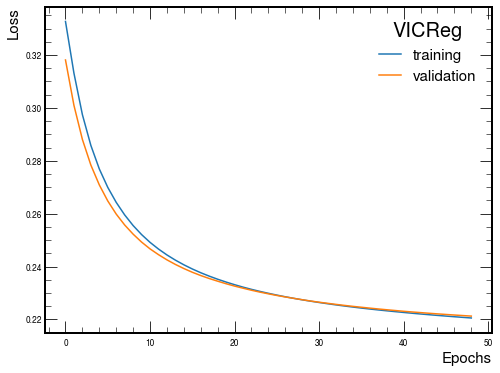

In [17]:
# plot the total loss
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    range(len(losses_train_VICRreg[1:])),
    losses_train_VICRreg[1:],
    label="training",
)
ax.plot(
    range(len(losses_valid_VICRreg[1:])),
    losses_valid_VICRreg[1:],
    label="validation",
)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title="VICReg", loc="best", title_fontsize=20, fontsize=15);

# Train MLPF

In [22]:
class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=34,
        width=126,
        num_convs=2,
        k=8,
        embedding_dim=34,
        native_mlpf=False,
    ):
        super(MLPF, self).__init__()

        self.act = nn.ELU
        self.native_mlpf = native_mlpf  # boolean that is true for native mlpf and false for ssl

        if native_mlpf:
            # embedding of the inputs that is necessary for native mlpf training
            self.nn0 = nn.Sequential(
                nn.Linear(input_dim, 126),
                self.act(),
                nn.Linear(126, 126),
                self.act(),
                nn.Linear(126, 126),
                self.act(),
                nn.Linear(126, embedding_dim),
            )

        # GNN that uses the embeddings learnt by VICReg as the input features
        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(
                GravNetConv(
                    embedding_dim,
                    embedding_dim,
                    space_dimensions=4,
                    propagate_dimensions=22,
                    k=k,
                )
            )

        # DNN that acts on the node level to predict the PID
        self.nn = nn.Sequential(
            nn.Linear(embedding_dim, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, width),
            self.act(),
            nn.Linear(width, NUM_CLASSES),
        )

    def forward(self, batch):

        # unfold the Batch object
        input_ = batch.x.float()
        batch = batch.batch

        # if `native_mlpf` then use then embed the inputs first (otherwise VICReg provides the embeddings)
        if self.native_mlpf:
            embedding = self.nn0(input_)
        else:
            embedding = input_

        # perform a series of graph convolutions
        for num, conv in enumerate(self.conv):
            embedding = conv(embedding, batch)

        # predict the PIDs
        preds_id = self.nn(embedding)

        return preds_id


In [23]:
def compute_weights(target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights


def train_mlpf(device, data, batch_size, model, mode, epochs):

    data_train = data[:4000]
    data_val = data[4000:5000]
    data_test = data[5000:]

    train_loader = DataLoader(data_train, batch_size)
    val_loader = DataLoader(data_val, batch_size)
    test_loader = DataLoader(data_test, batch_size)

    lr = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # , momentum= 0.9, weight_decay=1.5e-4)

    patience = 20
    best_val_loss = 99999.9
    stale_epochs = 0

    losses_train, losses_valid = [], []

    encoder.eval()
    decoder.eval()

    for epoch in tqdm(range(epochs)):

        model.train()
        loss_train = 0
        for batch in tqdm(train_loader):
            if mode == "ssl":
                # make transformation
                tracks, clusters = distinguish_PFelements(batch.to(device))

                # ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)

                tracks.x = embedding_tracks
                clusters.x = embedding_clusters

                event = combine_PFelements(tracks, clusters)

            elif mode == "native":
                event = batch.to(device)
            
            # make mlpf forward pass
            pred_ids_one_hot = model(event)
            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id

            weights = compute_weights(target_ids, num_classes=6)  # to accomodate class imbalance
            loss = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids, weight=weights)  # for classifying PID

            # update parameters
            for param in model.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

            loss_train += loss.detach()

        model.eval()
        loss_valid = 0
        with torch.no_grad():
            for batch in tqdm(val_loader):
                time.time()
                if mode == "ssl":
                    # make transformation
                    tracks, clusters = distinguish_PFelements(batch.to(device))

                    # ENCODE
                    embedding_tracks, embedding_clusters = encoder(tracks, clusters)

                    tracks.x = embedding_tracks
                    clusters.x = embedding_clusters

                    event = combine_PFelements(tracks, clusters)

                elif mode == "native":
                    event = batch.to(device)

                # make mlpf forward pass
                pred_ids_one_hot = model(event)
                pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
                target_ids = event.ygen_id

                weights = compute_weights(
                    target_ids, num_classes=6
                )  # to accomodate class imbalance
                loss = torch.nn.functional.cross_entropy(
                    pred_ids_one_hot, target_ids, weight=weights
                )  # for classifying PID

                loss_valid += loss.detach()

        print(
            f"epoch {epoch} - train: {round(loss_train.item(),3)} - valid: {round(loss_valid.item(), 3)} - stale={stale_epochs}")

        losses_train.append(loss_train / len(train_loader))
        losses_valid.append(loss_valid / len(val_loader))

        # early-stopping
        if losses_valid[epoch] < best_val_loss:
            best_val_loss = losses_valid[epoch]
            stale_epochs = 0
        else:
            stale_epochs += 1

    fig, ax = plt.subplots()
    ax.plot(range(len(losses_train[1:])), losses_train[1:], label="training")
    ax.plot(range(len(losses_valid[1:])), losses_valid[1:], label="validation")
    ax.set_xlabel("Epochs", fontsize=15)
    ax.set_ylabel("Loss", fontsize=15)
    ax.legend(title=f"{mode} MLPF", loc="best", title_fontsize=20, fontsize=15)
    return losses_train, losses_valid

In [24]:
# train ssl version of MLPF
mlpf_ssl = MLPF(embedding_dim=34, native_mlpf=False)
print("Num of model paramaters: ", sum(p.numel() for p in mlpf_ssl.parameters() if p.requires_grad))

Num of model paramaters:  44368



epoch 0 - train: 14.36 - valid: 3.476 - stale=0



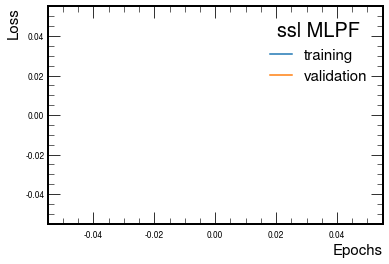

In [25]:
batch_size = 500
epochs=1
losses_train_ssl, losses_valid_ssl = train_mlpf(device, data, batch_size, mlpf_ssl, mode="ssl", epochs=epochs)

In [32]:
input_ = max(CLUSTERS_X, TRACKS_X) + 1   # max cz we concatenate them & +1 cz there's the `type` feature

mlpf_native = MLPF(input_dim=input_, native_mlpf=True)
print("Num of model paramaters: ",sum(p.numel() for p in mlpf_native.parameters() if p.requires_grad))

Num of model paramaters:  82832



epoch 0 - train: 16.247 - valid: 3.384 - stale=0



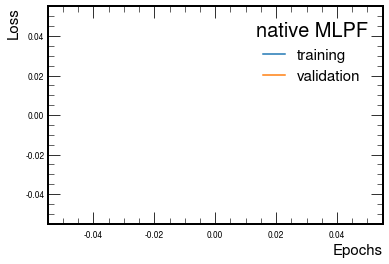

In [33]:
# train native MLPF
batch_size = 500
epochs = 1
losses_train_native, losses_valid_native = train_mlpf(device, data, batch_size, mlpf_native, mode="native", epochs=epochs)

# Compare native vs SSL

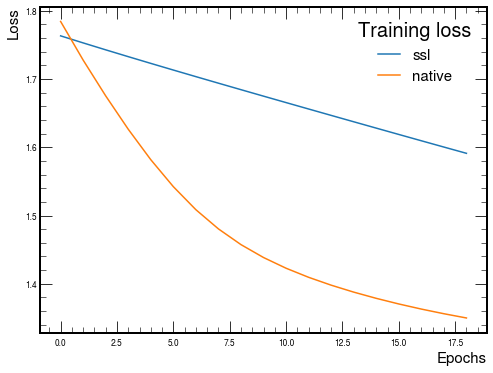

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(losses_train_ssl[1:])), losses_train_ssl[1:], label="ssl")
ax.plot(
    range(len(losses_train_native[1:])),
    losses_train_native[1:],
    label="native",
)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title="Training loss", loc="best", title_fontsize=20, fontsize=15);

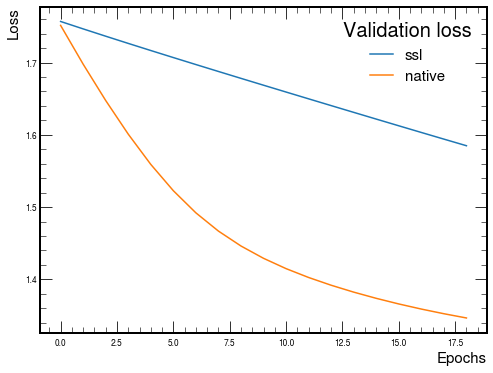

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(losses_valid_ssl[1:])), losses_valid_ssl[1:], label="ssl")
ax.plot(
    range(len(losses_valid_native[1:])),
    losses_valid_native[1:],
    label="native",
)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.legend(title="Validation loss", loc="best", title_fontsize=20, fontsize=15);

# Evaluate the SSL against native MLPF

In [34]:
CLASS_TO_ID = {
    "charged_hadron": 1,
    "neutral_hadron": 2,
#     "photon": 3,
#     "electron": 4,
#     "muon": 5,
}

def make_multiplicity_plots(npred, ngen, ncand, mode):
    for class_ in CLASS_TO_ID.keys():

        # Plot the particle multiplicities
        plt.figure(figsize=(6,6))
        plt.axes()
        plt.scatter(ngen[class_], ncand[class_], marker=".", alpha=0.4, label="PF")
        plt.scatter(ngen[class_], npred[class_], marker=".", alpha=0.4, label="MLPF")
        a = 0.5 * min(np.min(npred[class_]), np.min(ngen[class_]))
        b = 1.5 * max(np.max(npred[class_]), np.max(ngen[class_]))
        plt.xlim(a, b)
        plt.ylim(a, b)
        plt.plot([a, b], [a, b], color="black", ls="--")
        plt.title(class_)
        plt.xlabel("number of truth particles")
        plt.ylabel("number of reconstructed particles")
        plt.legend(loc=4)
        plt.show()
        
def make_conf_matrix(cm, mode):
    import itertools

    cmap = plt.get_cmap("Blues")
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    plt.figure(figsize=(8, 6))
    plt.axes()
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            "{:0.2f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=15,
        )
    if mode=="ssl":
        plt.title(f"{mode} based MLPF", fontsize=25)
    else:
        plt.title(f"{mode} MLPF", fontsize=25)
    plt.xlabel("Predicted label", fontsize=15)
    plt.ylabel("True label", fontsize=15)

    plt.xticks(
        range(len(CLASS_NAMES_CLIC_LATEX)),
        CLASS_NAMES_CLIC_LATEX,
        rotation=45,
        fontsize=15,
    )
    plt.yticks(range(len(CLASS_NAMES_CLIC_LATEX)), CLASS_NAMES_CLIC_LATEX, fontsize=15)

    plt.tight_layout()

In [90]:
def evaluate(device, encoder, decoder, mlpf, batch_size_mlpf, mode, data):

    npred, ngen, ncand = {}, {}, {}
    for class_ in CLASS_TO_ID.keys():
        npred[class_], ngen[class_], ncand[class_] = [], [], []

    test_loader = torch_geometric.loader.DataLoader(data, batch_size_mlpf)

    mlpf.eval()
    encoder.eval()
    decoder.eval()
    conf_matrix = np.zeros((6, 6))
    with torch.no_grad():
        for i, batch in enumerate(test_loader):

            if mode == "ssl":
                # make transformation
                tracks, clusters = distinguish_PFelements(batch.to(device))

                # ENCODE
                embedding_tracks, embedding_clusters = encoder(tracks, clusters)
                # POOLING
                pooled_tracks = global_mean_pool(embedding_tracks, tracks.batch)
                pooled_clusters = global_mean_pool(embedding_clusters, clusters.batch)
                # DECODE
                out_tracks, out_clusters = decoder(pooled_tracks, pooled_clusters)

                # use the learnt representation as your input as well as the global feature vector
                tracks.x = embedding_tracks
                clusters.x = embedding_clusters

                event = combine_PFelements(tracks, clusters)
                b_ = event.batch
                
            elif mode == "native":
                event = batch
            
            # make mlpf forward pass
            pred_ids_one_hot = mlpf(event.to(device))

            pred_ids = torch.argmax(pred_ids_one_hot, axis=1)
            target_ids = event.ygen_id
            cand_ids = event.ycand_id

            conf_matrix += sklearn.metrics.confusion_matrix(
                target_ids.detach().cpu(),
                pred_ids.detach().cpu(),
                labels=range(NUM_CLASSES),
            )
            
            # for multiplicity plots, must reduce the batch dimension
            for batch_index in range(batch_size_mlpf):
                # unpack the batch
                pred_id = pred_ids[event.batch==batch_index]
                target_id = target_ids[event.batch==batch_index]
                cand_id = cand_ids[event.batch==batch_index]
                
                for class_, id_ in CLASS_TO_ID.items():
                    npred[class_].append((pred_id == id_).sum().item())
                    ngen[class_].append((target_id == id_).sum().item())
                    ncand[class_].append((cand_id == id_).sum().item())

        make_conf_matrix(conf_matrix, mode)
        make_multiplicity_plots(npred, ngen, ncand, mode)

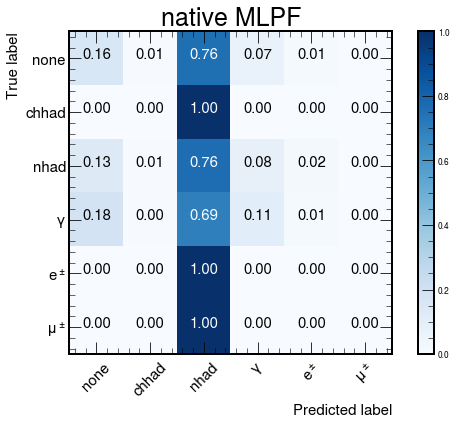

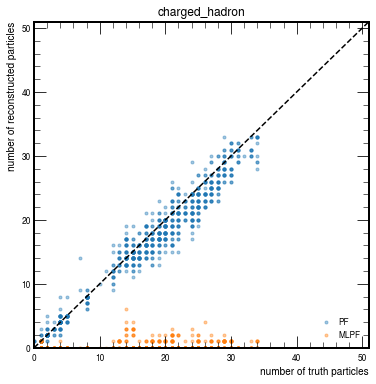

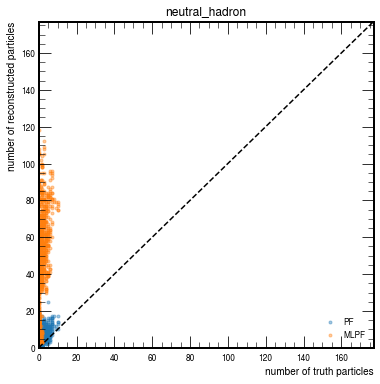

In [91]:
# evaluate native mlpf
batch_size_mlpf = 2
evaluate(
    device,
    encoder,
    decoder,
    mlpf_native,
    batch_size_mlpf,
    "native",
    data[:1000],
)

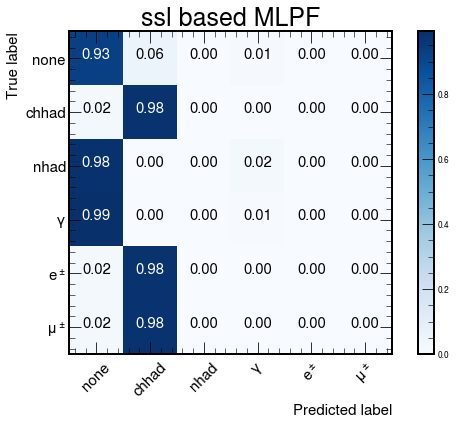

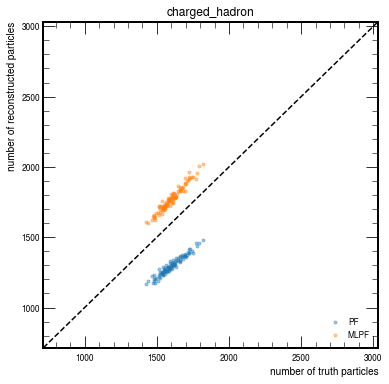

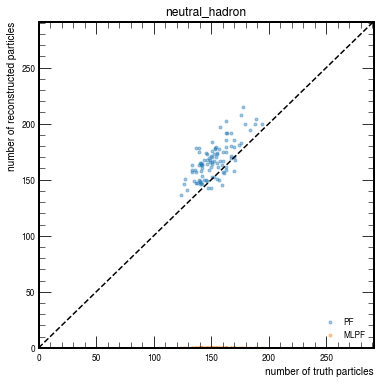

In [29]:
# evaluate ssl based mlpf
batch_size_mlpf = 50
evaluate(
    device,
    encoder,
    decoder,
    mlpf_ssl,
    batch_size_mlpf,
    "ssl",
    data[:5000],
)

In [31]:
batch

Batch(x=[2041, 12], ygen=[2041, 5], ygen_id=[2041], ycand=[2041, 5], ycand_id=[2041], batch=[2041], ptr=[21])